##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import re
import numpy as np
import os
import io
import time
import ast
import pandas as pd

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Download and prepare the dataset

After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [3]:
import os
#os.system("git clone https://github.com/soerenetler/squad-question-generation.git")
#os.system("git clone https://github.com/soerenetler/spacy_target_answer.git")
#os.system("git clone https://github.com/soerenetler/crf_target_answer.git")

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path_to_folder = "/content/gdrive/MyDrive/mt-qg-data/01_data/preprocessedData/squad/question_answer/"
path_to_model = "/content/gdrive/MyDrive/mt-qg-data/00_models/qg_attention/squad/"

In [15]:
class QGDataset:
  def __init__(self, problem_type='squad', data_folder="/content/gdrive/MyDrive/mt-qg-data/01_data/preprocessedData/"):
    self.problem_type = problem_type
    self.dev_path = data_folder + problem_type + "/question_answer/dev.csv"
    self.train_path = data_folder + problem_type + "/question_answer/train.csv"
    self.inp_lang_tokenizer = None
    self.targ_lang_tokenizer = None

  # Converts the unicode file to ascii
  def unicode_to_ascii(self, s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')
  
  def preprocess_sentence(self, w):
    w_result = ['<start>']
    for t in w:
      t = self.unicode_to_ascii(t.lower().strip())

      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
      t = re.sub(r"[^a-zA-Z\d?.!,¿]+", " ", t)

      t = t.strip()
      if t != '':
        w_result.append(t)
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w_result.append('<end>')
    return w_result

  # 1. Remove the accents
  # 2. Clean the sentences
  # 3. Return word pairs in the format: [ENGLISH, SPANISH]
  def create_dataset(self, path):
    df = pd.read_csv(path)
    df["answer_sentence_token"] = [ast.literal_eval(t) for t in df["answer_sentence_token"]]
    df["question_token"] = [ast.literal_eval(t) for t in df["question_token"]]

    #from plotly import express
    #display(express.histogram(x=[len(t) for t in df["answer_sentence_token"]]))

    #display(df["answer_sentence_token"].head(50))

    sentence_pairs = zip(df["answer_sentence_token"].apply(self.preprocess_sentence), df["question_token"].apply(self.preprocess_sentence))
    

    return zip(*sentence_pairs)

  def tokenize(self, lang, maxlen):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          maxlen=maxlen,
                                                          padding='post')

    return tensor, lang_tokenizer

  def load_dataset(self):
    # creating cleaned input, output pairs
    inp_lang_train, targ_lang_train = self.create_dataset(self.train_path)
    inp_lang_dev, targ_lang_dev = self.create_dataset(self.dev_path)

    print(inp_lang_train[-1])
    print(targ_lang_train[-1])

    input_tensor, inp_lang_tokenizer = self.tokenize(inp_lang_train, max_length_inp)
    target_tensor, targ_lang_tokenizer = self.tokenize(targ_lang_train, max_length_targ)

    print(inp_lang_dev[0])
    print(targ_lang_dev[0])
    input_tensor_dev = inp_lang_tokenizer.texts_to_sequences(inp_lang_dev)
    target_tensor_dev = targ_lang_tokenizer.texts_to_sequences(targ_lang_dev)
    print(input_tensor_dev[0])
    print(target_tensor_dev[0])

    return input_tensor, target_tensor, input_tensor_dev, target_tensor_dev, inp_lang_tokenizer, targ_lang_tokenizer

In [42]:
answer_sentence = ['3245', 'two', 'months', 'later', 'the', 'band', 'got', 'signed', 'to', 'a', 'three', 'album', 'deal', 'with', 'spinefarm', ',', 'which', 'left', 'marko', 'displeased', '.']
question_sentence = ['what', 'label', 'were', 'they', 'with', '?']

qg_dataset = QGDataset()
print(qg_dataset.preprocess_sentence(answer_sentence))
print(qg_dataset.preprocess_sentence(question_sentence))

['<start>', '3245', 'two', 'months', 'later', 'the', 'band', 'got', 'signed', 'to', 'a', 'three', 'album', 'deal', 'with', 'spinefarm', ',', 'which', 'left', 'marko', 'displeased', '.', '<end>']
['<start>', 'what', 'label', 'were', 'they', 'with', '?', '<end>']


### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [17]:
# max_length of the target tensors
max_length_targ = 20
max_length_inp = 80

# Try experimenting with the size of that dataset
input_tensor_train, target_tensor_train, input_tensor_dev, target_tensor_dev, inp_tokenizer, targ_tokenizer = qg_dataset.load_dataset()

['<start>', 'according', 'to', 'the', 'government', 'of', 'botswana', ',', 'trophy', 'hunting', 'is', 'at', 'least', 'partly', 'to', 'blame', 'for', 'this', ',', 'but', 'many', 'other', 'factors', ',', 'such', 'as', 'poaching', ',', 'drought', 'and', 'habitat', 'loss', 'are', 'also', 'to', 'blame', '.', '<end>']
['<start>', 'what', 'else', 'is', 'partly', 'to', 'blame', 'for', 'the', 'declining', 'number', 'of', 'animals', 'in', 'botswana', 'and', 'uganda', '?', '<end>']
['<start>', 'the', 'legend', 'of', 'zelda', 'twilight', 'princess', 'japanese', ',', 'hepburn', 'zeruda', 'no', 'densetsu', 'towairaito', 'purinsesu', '?', 'is', 'an', 'action', 'adventure', 'game', 'developed', 'and', 'published', 'by', 'nintendo', 'for', 'the', 'gamecube', 'and', 'wii', 'home', 'video', 'game', 'consoles', '.', '<end>']
['<start>', 'what', 'category', 'of', 'game', 'is', 'legend', 'of', 'zelda', 'twilight', 'princess', '?', '<end>']
[4, 1, 5737, 3, 51160, 43600, 4311, 390, 2, 30832, 116, 1835, 12, 25

In [18]:
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_dev), len(target_tensor_dev))

68174 68174 18647 18647


In [19]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [21]:
print ("Input Language; index to word mapping")
convert(inp_tokenizer, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_tokenizer, target_tensor_train[0])

Input Language; index to word mapping
4 ----> <start>
646 ----> born
7 ----> and
1204 ----> raised
8 ----> in
3955 ----> houston
2 ----> ,
2469 ----> texas
2 ----> ,
335 ----> she
1054 ----> performed
8 ----> in
268 ----> various
2727 ----> singing
7 ----> and
6945 ----> dancing
3424 ----> competitions
11 ----> as
10 ----> a
642 ----> child
2 ----> ,
7 ----> and
1701 ----> rose
9 ----> to
3163 ----> fame
8 ----> in
1 ----> the
193 ----> late
1220 ----> 1990s
11 ----> as
935 ----> lead
2308 ----> singer
3 ----> of
3090 ----> r b
5851 ----> girl
199 ----> group
3025 ----> destiny
19 ----> s
642 ----> child
6 ----> .
5 ----> <end>

Target Language; index to word mapping
1 ----> <start>
19 ----> when
11 ----> did
105 ----> beyonce
161 ----> start
1593 ----> becoming
207 ----> popular
3 ----> ?
2 ----> <end>


### Create a tf.data dataset

In [22]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_tokenizer.word_index)+2 #OOV + PADDING
vocab_tar_size = len(targ_tokenizer.word_index)+2

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [23]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 80]), TensorShape([64, 20]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [24]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [25]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 80, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [27]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 80, 1)


In [83]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_type='luong'):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.attention_type = attention_type

    # Embedding Layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # Define the fundamental cell for decoder recurrent structure
    self.gru = tf.keras.layers.GRUCell(self.dec_units,
                                   recurrent_initializer='glorot_uniform')
    
    #Final Dense layer on which softmax will be applied
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Sampler
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()

    # Create attention mechanism with memory = None
    self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
                                                              None, self.batch_sz*[max_length_inp], self.attention_type)

    # Wrap attention mechanism with the fundamental rnn cell of decoder
    self.rnn_cell = tfa.seq2seq.AttentionWrapper(self.gru, 
                                  self.attention_mechanism, attention_layer_size=self.dec_units)
    
    # Define the decoder with respect to fundamental rnn cell
    self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler=self.sampler, output_layer=self.fc)

  def build_attention_mechanism(self, dec_units, memory, memory_sequence_length, attention_type='luong'):
    # ------------- #
    # typ: Which sort of attention (Bahdanau, Luong)
    # dec_units: final dimension of attention outputs 
    # memory: encoder hidden states of shape (batch_size, max_length_input, enc_units)
    # memory_sequence_length: 1d array of shape (batch_size) with every element set to max_length_input (for masking purpose)

    if(attention_type=='bahdanau'):
      return tfa.seq2seq.BahdanauAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)
    else:
      return tfa.seq2seq.LuongAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)

  def build_initial_state(self, batch_sz, encoder_state, Dtype):
    decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype)
    decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
    return decoder_initial_state

  def call(self, x, hidden):
    # enc_output shape == (batch_size, max_length, hidden_size)
    # context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    #x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    #output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    #output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    # x = self.fc(output)

    #return x, state, attention_weights

    outputs, _, _ = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[max_length_targ-1])
    return outputs

In [84]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 'luong')

#sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
#                                      sample_hidden, sample_output)

#print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

In [85]:
sample_x = tf.random.uniform((BATCH_SIZE, max_length_targ))
decoder.attention_mechanism.setup_memory(sample_output)
initial_state = decoder.build_initial_state(BATCH_SIZE, sample_hidden, tf.float32)


sample_decoder_outputs = decoder(sample_x, initial_state)

print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)


Decoder Outputs Shape:  (64, 19, 32377)


## Define the optimizer and the loss function

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [31]:
checkpoint_dir = path_to_model + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 2

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [43]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = qg_dataset.preprocess_sentence(sentence)

  inputs = inp_tokenizer.texts_to_sequences([sentence])
  print(inputs)
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = []

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result.append(targ_tokenizer.index_word[predicted_id])

    if targ_tokenizer.index_word[predicted_id] == '<end>':
      print(attention_plot.shape)
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [39]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  print(attention.shape)
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [40]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result), :len(sentence)]
  plot_attention(attention_plot, sentence, result)

## Restore the latest checkpoint and test

In [34]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

[[4, 60, 853, 110, 1, 969, 5186, 825, 9, 10, 90, 672, 1703, 16, 2, 21, 540, 6, 5]]
Input: ['<start>', 'two', 'months', 'later', 'the', 'band', 'got', 'signed', 'to', 'a', 'three', 'album', 'deal', 'with', ',', 'which', 'left', '.', '<end>']
Predicted translation: ['what', 'was', 'the', 'name', 'of', 'the', 'song', 'that', 'the', 'song', 'spent', 'at', 'the', 'film', 'at', 'the', 'film', 'about', 'the', 'song']
(20, 19)


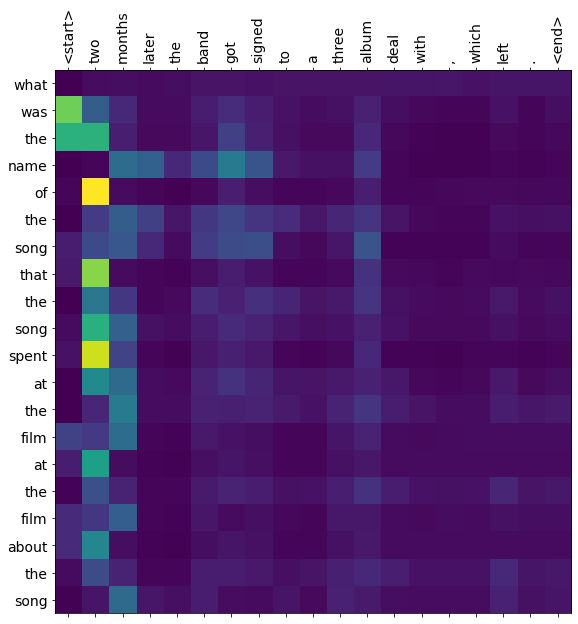

In [44]:
translate(['two', 'months', 'later', 'the', 'band', 'got', 'signed', 'to', 'a', 'three', 'album', 'deal', 'with', ',', 'which', 'left', '.'])

[[4, 12, 10, 29451, 3, 16217, 2, 1, 282, 3, 1, 130, 62, 3, 7243, 6, 5]]
(20, 80)
Input: ['<start>', 'golm', 'is', 'a', 'locality', 'of', 'potsdam', ',', 'the', 'capital', 'of', 'the', 'german', 'state', 'of', 'brandenburg', '.', '<end>']
Predicted translation: ['what', 'is', 'an', 'objective', 'of', 'treaty', 'been', 'denounced', '?', '<end>']
(10, 18)


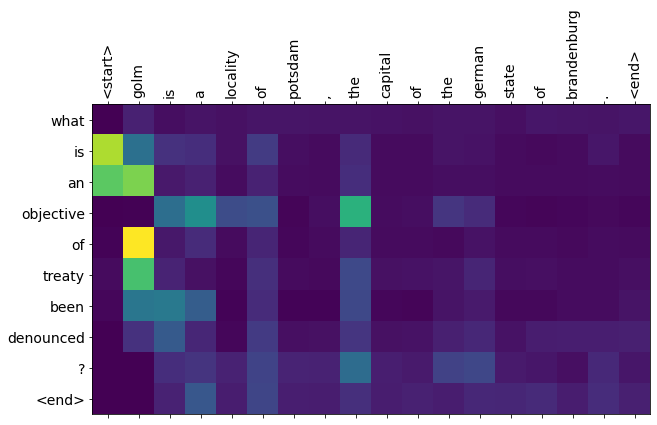

In [45]:
translate(["Golm", "is", "a", "locality", "of", "Potsdam", ",", "the", "capital", "of", "the", "German", "state", "of", "Brandenburg", "."])

[[4, 1, 120, 3, 76, 12, 1, 417, 567, 2, 40, 3, 1, 120, 36, 567, 3490, 8, 1, 791, 6, 5]]
(20, 80)
Input: ['<start>', 'the', 'largest', 'of', 'these', 'is', 'the', 'eldon', 'square', 'shop ping', 'centre', ',', 'one', 'of', 'the', 'largest', 'city', 'centre', 'shopping', 'com plexes', 'in', 'the', 'uk', '.', '<end>']
Predicted translation: ['what', 'is', 'the', 'largest', 'residential', 'train', 'service', '?', '<end>']
(9, 25)


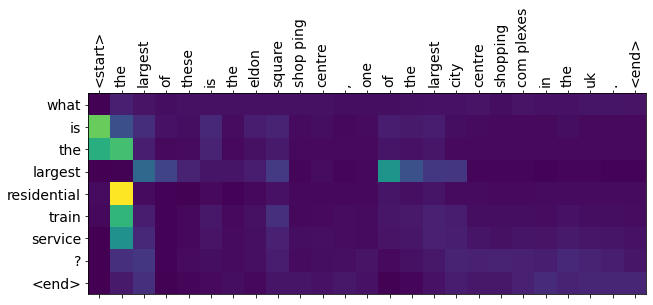

In [46]:
translate("the largest of these is the eldon square shop-ping centre , one of the largest city centre shopping com-plexes in the uk .".split(" "))

In [55]:
def beam_evaluate_sentence(sentence, beam_width=3):
  sentence = qg_dataset.preprocess_sentence(sentence)

  inputs = inp_tokenizer.texts_to_sequences([sentence])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                          maxlen=max_length_inp,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = []

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden

  start_tokens = tf.fill([inference_batch_size], targ_tokenizer.word_index['<start>'])
  end_token = targ_tokenizer.word_index['<end>']

  # From official documentation
  # NOTE If you are using the BeamSearchDecoder with a cell wrapped in AttentionWrapper, then you must ensure that:
  # The encoder output has been tiled to beam_width via tfa.seq2seq.tile_batch (NOT tf.tile).
  # The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
  # The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.

  enc_out = tfa.seq2seq.tile_batch(enc_out, multiplier=beam_width)
  decoder.attention_mechanism.setup_memory(enc_out)
  print("beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] :", enc_out.shape)

  # set decoder_inital_state which is an AttentionWrapperState considering beam_width
  hidden_state = tfa.seq2seq.tile_batch(enc_hidden, multiplier=beam_width)
  decoder_initial_state = decoder.rnn_cell.get_initial_state(batch_size=beam_width*inference_batch_size, dtype=tf.float32)
  decoder_initial_state = decoder_initial_state.clone(cell_state=hidden_state)

  # Instantiate BeamSearchDecoder
  decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoder.rnn_cell,beam_width=beam_width, output_layer=decoder.fc)
  decoder_embedding_matrix = decoder.embedding.variables[0]

  # The BeamSearchDecoder object's call() function takes care of everything.
  outputs, final_state, sequence_lengths = decoder_instance(decoder_embedding_matrix, start_tokens=start_tokens, end_token=end_token, initial_state=decoder_initial_state)
  # outputs is tfa.seq2seq.FinalBeamSearchDecoderOutput object. 
  # The final beam predictions are stored in outputs.predicted_id
  # outputs.beam_search_decoder_output is a tfa.seq2seq.BeamSearchDecoderOutput object which keep tracks of beam_scores and parent_ids while performing a beam decoding step
  # final_state = tfa.seq2seq.BeamSearchDecoderState object.
  # Sequence Length = [inference_batch_size, beam_width] details the maximum length of the beams that are generated


  # outputs.predicted_id.shape = (inference_batch_size, time_step_outputs, beam_width)
  # outputs.beam_search_decoder_output.scores.shape = (inference_batch_size, time_step_outputs, beam_width)
  # Convert the shape of outputs and beam_scores to (inference_batch_size, beam_width, time_step_outputs)
  final_outputs = tf.transpose(outputs.predicted_ids, perm=(0,2,1))
  beam_scores = tf.transpose(outputs.beam_search_decoder_output.scores, perm=(0,2,1))

  return final_outputs.numpy(), beam_scores.numpy()


In [56]:
def beam_translate(sentence):
  result, beam_scores = beam_evaluate_sentence(sentence)
  print(result.shape, beam_scores.shape)
  for beam, score in zip(result, beam_scores):
    print(beam.shape, score.shape)
    output = targ_lang.sequences_to_texts(beam)
    output = [a[:a.index('<end>')] for a in output]
    beam_score = [a.sum() for a in score]
    print('Input: %s' % (sentence))
    for i in range(len(output)):
      print('{} Predicted translation: {}  {}'.format(i+1, output[i], beam_score[i]))


In [57]:
beam_translate("the largest of these is the eldon square shop-ping centre , one of the largest city centre shopping com-plexes in the uk .".split(" "))

AttributeError: ignored